In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import onnx
import onnxruntime
from onnxruntime.quantization import quantize_dynamic, QuantType
import bentoml
import torch.nn.functional as F
from bentoml.io import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.onnx
import asyncio


### Модель

In [2]:
class NetBN(nn.Module):  # Новое имя класса для модели с BN
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # <- Исправлено
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # BN после conv1 и ReLU
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # BN после conv2 и ReLU
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Тренировка + Тестирование

In [3]:
def train(model, optimizer, epochs, trainloader, series='default'):
    criterion = nn.CrossEntropyLoss() # Используем CrossEntropyLoss
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        train_accuracy = test(model, trainloader, "Train")
        print(f'Train Epoch: {epoch}\tLoss: {loss.item():.6f}\tAccuracy: {train_accuracy:.2f}%')


def test(model, dataloader, data_type="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Используем CrossEntropyLoss
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print(f'\n{data_type} set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy

### Датасет

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 1024

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### Обучение модели

In [6]:
model = NetBN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, epochs=26, trainloader=trainloader, series='Adam Optimizer')
test_accuracy_bn = test(model, testloader)


Train set: Average loss: 3.5947, Accuracy: 7329/50000 (15%)

Train Epoch: 1	Loss: 3.585986	Accuracy: 14.66%

Train set: Average loss: 3.1474, Accuracy: 11633/50000 (23%)

Train Epoch: 2	Loss: 3.182037	Accuracy: 23.27%

Train set: Average loss: 2.9141, Accuracy: 13793/50000 (28%)

Train Epoch: 3	Loss: 2.960262	Accuracy: 27.59%

Train set: Average loss: 2.7309, Accuracy: 15723/50000 (31%)

Train Epoch: 4	Loss: 2.700692	Accuracy: 31.45%

Train set: Average loss: 2.6078, Accuracy: 17037/50000 (34%)

Train Epoch: 5	Loss: 2.717317	Accuracy: 34.07%

Train set: Average loss: 2.5474, Accuracy: 17426/50000 (35%)

Train Epoch: 6	Loss: 2.533091	Accuracy: 34.85%

Train set: Average loss: 2.4469, Accuracy: 18652/50000 (37%)

Train Epoch: 7	Loss: 2.580465	Accuracy: 37.30%

Train set: Average loss: 2.3766, Accuracy: 19492/50000 (39%)

Train Epoch: 8	Loss: 2.377970	Accuracy: 38.98%

Train set: Average loss: 2.3270, Accuracy: 19953/50000 (40%)

Train Epoch: 9	Loss: 2.334612	Accuracy: 39.91%

Train set:

### 2.1 Выбор устройства (CPU/GPU)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NetBN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
)

### 2.2 Измерение времени выполнения

In [8]:
def measure_time(model, input_tensor, device):
    start_time = time.time()
    model(input_tensor)  # Выполняем один проход модели
    end_time = time.time()
    return end_time - start_time

In [9]:

dummy_input_cpu = torch.randn(batch_size, 3, 32, 32).to("cpu")

# Измеряем время на CPU
cpu_time = measure_time(model, dummy_input_cpu, "cpu")

print(f"CPU time: {cpu_time:.4f} seconds")

CPU time: 0.2304 seconds


In [11]:
times = []
for i in range(10):
    times.append(measure_time(model, dummy_input_cpu, "cpu"))

times = pd.DataFrame({'measureTime': times})
print(times, times.mean(), sep='\n\n')

   measureTime
0     0.282132
1     0.188522
2     0.198553
3     0.195736
4     0.191503
5     0.189117
6     0.185271
7     0.194119
8     0.190160
9     0.208048

measureTime    0.202316
dtype: float64


### 2.3 Измерение точности

In [12]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # Переключаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():  # Не нужно вычислять градиенты
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) # Перемещаем данные на устройство
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Получаем предсказанные классы
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Считаем количество правильных ответов
    accuracy = 100 * correct / total
    return accuracy

In [13]:
test_accuracy = evaluate_accuracy(model, testloader, device)
print(f"Test accuracy: {test_accuracy:.2f}%")

Test accuracy: 48.96%


### 2.4 Сбор корректных и ошибочных примеров

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device) # Не забываем про device
outputs = model(images)
_, predicted = torch.max(outputs, 1)

correct_examples = [(images[i].cpu(), labels[i].cpu(), predicted[i].cpu()) for i in range(len(images)) if predicted[i] == labels[i]][:5] # added .cpu()
incorrect_examples = [(images[i].cpu(), labels[i].cpu(), predicted[i].cpu()) for i in range(len(images)) if predicted[i] != labels[i]][:5] # added .cpu()

In [15]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Примеры корректных предсказаний:
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'w

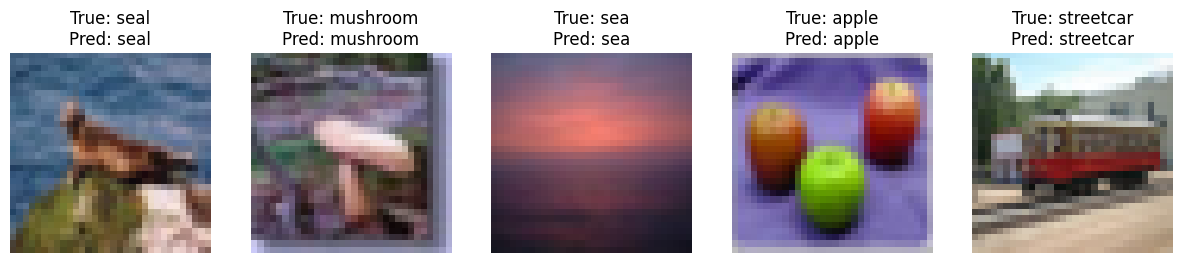

In [17]:
print("Примеры корректных предсказаний:")
classes = testset.classes
print(classes)
fig, axes = plt.subplots(1, len(correct_examples), figsize=(15, 3))
for i, (image, label, prediction) in enumerate(correct_examples):
    image = image.cpu() # Перемещаем тензор на CPU для matplotlib
    axes[i].imshow(np.transpose(image.numpy() / 2 + 0.5, (1, 2, 0))) # Денормализация и транспонирование для matplotlib
    axes[i].set_title(f"True: {classes[label]}\nPred: {classes[prediction]}")
    axes[i].axis('off') # Убираем оси
plt.show()

Примеры ошибочных предсказаний:


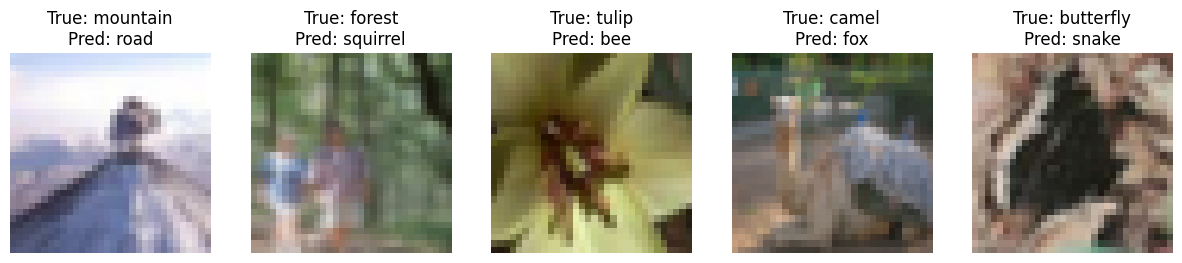

In [18]:
print("Примеры ошибочных предсказаний:")
fig, axes = plt.subplots(1, len(incorrect_examples), figsize=(15, 3))
for i, (image, label, prediction) in enumerate(incorrect_examples):
    image = image.cpu() # Перемещаем тензор на CPU для matplotlib
    axes[i].imshow(np.transpose(image.numpy() / 2 + 0.5, (1, 2, 0))) # Денормализация и транспонирование для matplotlib
    axes[i].set_title(f"True: {classes[label]}\nPred: {classes[prediction]}")
    axes[i].axis('off') # Убираем оси
plt.show()

### 3 - конвертация в ONNX и проверка качества и скорости
### 3.1 Экспорт модели в ONNX

In [19]:
dummy_input = torch.randn(batch_size, 3, 32, 32, device="cpu") # Входные данные должны быть на CPU

# Экспортируем модель
torch.onnx.export(
    model.cpu(),  # Модель должна быть на CPU
    dummy_input,
    "model.onnx",  # Имя ONNX файла
    verbose=True,  # Выводит информацию о процессе экспорта
    input_names=['input'],   # Имя входного тензора
    output_names=['output'], # Имя выходного тензора
    dynamic_axes={'input': {0: 'batch_size'},  # Указываем, что размер батча может меняться
                   'output': {0: 'batch_size'}},
    opset_version=11 #  Версия ONNX opset (выберите подходящую, например, 11)
)

Exported graph: graph(%input : Float(*, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %fc1.weight : Float(512, 4096, strides=[4096, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(100, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(100, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_33 : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_34 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_36 : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_37 : Float(64, strides=[1], requires_grad=0, device=cpu)):
  %/conv1/Conv_output_0 : Float(*, 32, 32, 32, strides=[32768, 1024, 32, 1], requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="/conv1/Conv"](%inp

### 3.2 Проверка ONNX модели (качество и скорость)

In [20]:
# Загружаем ONNX модель
onnx_model = onnx.load("model.onnx")

# Проверяем модель на корректность
onnx.checker.check_model(onnx_model)

# Создаем InferenceSession
ort_session = onnxruntime.InferenceSession("model.onnx", providers=['CPUExecutionProvider'])


# Тестируем ONNX модель на одном батче
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.cpu().numpy()  # Преобразуем в NumPy array и перемещаем на CPU

# Выполняем inference
ort_inputs = {ort_session.get_inputs()[0].name: images}
ort_outs = ort_session.run(None, ort_inputs)

# Получаем предсказания
predicted = np.argmax(ort_outs[0], axis=1)

In [21]:
# Тестируем ONNX модель

num_batches_to_check = 2 # Количество батчей для проверки

for i, (images, labels) in enumerate(testloader):
    if i >= num_batches_to_check:
        break

    pytorch_model = model.cpu()
    pytorch_model.eval()
    with torch.no_grad():
        pytorch_outputs = pytorch_model(images)
    pytorch_predicted = torch.argmax(pytorch_outputs, dim=1).numpy()

    # ONNX inference
    images_np = images.cpu().numpy() # Сохраняем NumPy массив для ONNX
    images = torch.from_numpy(images_np).to(device) # Преобразуем обратно в тензор и перемещаем на устройство

    ort_inputs = {ort_session.get_inputs()[0].name: images_np} # ONNX работает с NumPy массивом
    ort_outs = ort_session.run(None, ort_inputs)
    onnx_predicted = np.argmax(ort_outs[0], axis=1)

    # Сравнение
    allclose = np.allclose(pytorch_outputs.numpy(), ort_outs[0], atol=1e-4)
    print(f"Батч {i+1}: Выходные тензоры близки: {allclose}")

    # PyTorch inference (для сравнения)
    pytorch_model = model.cpu() # Убедимся, что модель на CPU
    pytorch_model.eval()
    with torch.no_grad():
        pytorch_outputs = pytorch_model(images)
    pytorch_predicted = torch.argmax(pytorch_outputs, dim=1).numpy()

    # ONNX inference
    images = images.cpu().numpy()  # Преобразуем в NumPy array и перемещаем на CPU
    ort_inputs = {ort_session.get_inputs()[0].name: images}
    ort_outs = ort_session.run(None, ort_inputs)
    onnx_predicted = np.argmax(ort_outs[0], axis=1)


    # Сравнение предсказаний
    print("Сравнение предсказаний PyTorch и ONNX:")
    print("  Количество совпадающих предсказаний:", np.sum(pytorch_predicted == onnx_predicted))
    print("  Количество несовпадающих предсказаний:", np.sum(pytorch_predicted != onnx_predicted))


    # Вычисление процента совпавших предсказаний
    match_percentage = np.sum(pytorch_predicted == onnx_predicted) / len(pytorch_predicted) * 100
    print(f"  Процент совпавших предсказаний: {match_percentage:.2f}%")
    print('-' * 10)

Батч 1: Выходные тензоры близки: True
Сравнение предсказаний PyTorch и ONNX:
  Количество совпадающих предсказаний: 1024
  Количество несовпадающих предсказаний: 0
  Процент совпавших предсказаний: 100.00%
----------
Батч 2: Выходные тензоры близки: True
Сравнение предсказаний PyTorch и ONNX:
  Количество совпадающих предсказаний: 1024
  Количество несовпадающих предсказаний: 0
  Процент совпавших предсказаний: 100.00%
----------


#### Измеряем время выполнения ONNX модели

In [22]:
start_time = time.time()
ort_session.run(None, ort_inputs)
end_time = time.time()
onnx_time = end_time - start_time
print(f"ONNX inference time: {onnx_time:.4f} seconds")

ONNX inference time: 0.0868 seconds


### 4.1 Сохранение ONNX модели в BentoML

In [24]:
model = NetBN()
model.eval()

dummy_input = torch.randn(1, 3, 32, 32, device="cpu")  # Пример входных данных

torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # Поддержка динамического размера батча
        "output": {0: "batch_size"}
    },
    opset_version=11  # Используйте opset 11 или выше
)
print("Модель успешно экспортирована в ONNX!")

Модель успешно экспортирована в ONNX!


In [25]:
onnx_model = onnx.load('model.onnx')

# Сохранение модели в BentoML
model_info = bentoml.onnx.save_model('model', onnx_model)
print(f"Model saved: {model_info}")


/var/folders/m8/xclh77116fv8fn8ck2n6sm1r0000gn/T/ipykernel_89302/3302604876.py:4: BentoMLDeprecationWarning: `bentoml.onnx` is deprecated since v1.4 and will be removed in a future version.
  model_info = bentoml.onnx.save_model('model', onnx_model)


Model saved: Model(tag="model:j5fp4wfwoglmgbwl")


In [27]:
model = onnx.load("model.onnx")
print(onnx.helper.printable_graph(model.graph))

graph main_graph (
  %input[FLOAT, batch_sizex3x32x32]
) initializers (
  %fc1.weight[FLOAT, 512x4096]
  %fc1.bias[FLOAT, 512]
  %fc2.weight[FLOAT, 100x512]
  %fc2.bias[FLOAT, 100]
  %onnx::Conv_33[FLOAT, 32x3x3x3]
  %onnx::Conv_34[FLOAT, 32]
  %onnx::Conv_36[FLOAT, 64x32x3x3]
  %onnx::Conv_37[FLOAT, 64]
) {
  %/conv1/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input, %onnx::Conv_33, %onnx::Conv_34)
  %/Relu_output_0 = Relu(%/conv1/Conv_output_0)
  %/pool/MaxPool_output_0 = MaxPool[ceil_mode = 0, dilations = [1, 1], kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%/Relu_output_0)
  %/conv2/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%/pool/MaxPool_output_0, %onnx::Conv_36, %onnx::Conv_37)
  %/Relu_1_output_0 = Relu(%/conv2/Conv_output_0)
  %/pool_1/MaxPool_output_0 = MaxPool[ceil_mode = 0, dilations = [1, 1], kernel_shape = [2, 2], p

In [28]:
model = NetBN()
model.eval()  # Включаем режим оценки

dummy_input = torch.randn(1, 3, 32, 32, device="cpu")
output = model(dummy_input)
print(f"Выход модели: {output}")


Выход модели: tensor([[ 0.0929,  0.1277, -0.1066, -0.0389, -0.0720, -0.1426,  0.0943,  0.0647,
         -0.0497, -0.1783, -0.1016,  0.0161,  0.1777, -0.0733,  0.0368, -0.0859,
          0.1355,  0.0833,  0.1620, -0.0519, -0.0321, -0.0914,  0.0171,  0.0402,
         -0.0811,  0.1196, -0.0010, -0.1913,  0.0778, -0.0469, -0.0270,  0.0465,
          0.1872, -0.0458, -0.0673, -0.0920,  0.0377,  0.0516,  0.0697,  0.0907,
          0.1031, -0.0886,  0.0879,  0.1402, -0.1755,  0.1451,  0.0093, -0.0553,
          0.0350,  0.0397,  0.0013, -0.0192, -0.0464, -0.0475, -0.0779, -0.1155,
         -0.0478,  0.1391,  0.0947, -0.0150,  0.0113, -0.1615,  0.0753, -0.1470,
          0.0456, -0.1066, -0.1042,  0.0877,  0.0122,  0.0600,  0.0416, -0.0034,
          0.0948, -0.0684, -0.0351,  0.0480, -0.2253, -0.0241,  0.1591,  0.0261,
         -0.1790,  0.0646, -0.0093, -0.1146, -0.1000, -0.0399,  0.0233,  0.0850,
         -0.2756,  0.0318,  0.0507,  0.0310,  0.0672,  0.1223, -0.2261, -0.0800,
         -0.01

In [31]:
model = onnx.load("model.onnx")
print([inp.name for inp in model.graph.input])
print("Inputs:", [inp.name for inp in model.graph.input])
print("Outputs:", [out.name for out in model.graph.output])

['input']
Inputs: ['input']
Outputs: ['output']


In [33]:
from torchvision import datasets, transforms
from PIL import Image

# Преобразования для загрузки данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка тестового набора CIFAR-100
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True)

def get_test_image(index):
    image, label = cifar100_test[index]
    
    # Убедимся, что изображение остается в формате PIL
    if not isinstance(image, Image.Image):
        raise TypeError("Ожидалось изображение формата PIL.Image.Image")

    return image, label


# Получаем тестовое изображение из набора данных
index = 55  # Выберите индекс изображения для проверки
for index in range(len(cifar100_test)):
    image, true_label = get_test_image(index)
    if true_label == 90:
        image.save("test_image.png")
        print(true_label)
        break

# Сохраняем изображение во временный файл




Files already downloaded and verified
90


In [34]:
Предсказания_модели =  [[ 0.05252775,  0.09221028,  0.03430457,  0.02618705, -0.00098768, -0.01095299,
   0.05462858,  0.00583726, -0.02481419, -0.01800504,  0.03846728, -0.01135343,
   0.00587154,  0.05012177,  0.04293617,  0.0089918 ,  0.0450828 ,  0.02568796,
   0.0049684 ,  0.0683031 , -0.00042762, -0.00359162, -0.04394936, -0.00207978,
   0.01393015, -0.00442521, -0.06815515,  0.01085533, -0.06154749, -0.03924913,
  -0.02413696, -0.05534253,  0.0296553 ,  0.05884004, -0.03218215, -0.1066132,
   0.0014639 ,  0.00449299, -0.0172291 ,  0.00324668,  0.0324656 ,  0.03362614,
  -0.03693506, -0.00198995, -0.05162738,  0.00266843,  0.0638847 ,  0.01650134,
  -0.05344574,  0.04742242, -0.05238026, -0.01484452, -0.0329713 , -0.02386306,
  -0.09885512, -0.00761616,  0.00329509,  0.02040965,  0.06252515, -0.02462349,
  -0.01357918, -0.02723316, -0.0141856 , -0.00944939,  0.0272883 , -0.04567043,
   0.04106239, -0.06272586, -0.03844174, -0.04477257,  0.00347908,  0.04951301,
  -0.04091697, -0.02564267,  0.00882641,  0.03433892, -0.00627957,  0.00691216,
   0.01513059, -0.063981  ,  0.02678045,  0.0755907 ,  0.02515469, -0.01445019,
   0.00590374, -0.00361215,  0.10981321,  0.02743248,  0.00513484, -0.00297958,
   0.03737761,  0.00138457, -0.01087777,  0.07175264, -0.07444374,  0.01662439,
  -0.04005085, -0.04793993, -0.02037536, -0.04286731]]

Предсказания_модели_2 = [[ 0.02275437,  0.11194085,  0.01090562,  0.04444422, -0.0137661,   0.03066877,
   0.08573227,  0.01233844,  0.02726423, -0.04179883,  0.02312686, -0.03754495,
   0.00144991,  0.05260397,  0.03391289, -0.03487739,  0.03372299,  0.02582743,
   0.00650662,  0.05231199,  0.00645558,  0.00188751,  0.00117265,  0.0096965,
   0.00740847, -0.02461424, -0.03226116, -0.04985425, -0.08529495,  0.02295388,
  -0.06884638, -0.07331162,  0.05683734,  0.04121794, -0.03858969, -0.13839206,
  -0.0101495 ,  0.00602387,  0.00261351, -0.06169346,  0.04998262,  0.05129063,
  -0.00082454, -0.01160536, -0.02691049,  0.03053112,  0.03649314,  0.0070515,
  -0.06157798,  0.03331311, -0.05542872,  0.0255947 , -0.03518035, -0.06720892,
  -0.08607268, -0.01472732,  0.00210573,  0.03916719,  0.06278649, -0.00666796,
   0.00532947, -0.06364912, -0.0313621 ,  0.01405161,  0.03254362, -0.07201681,
   0.04215445, -0.11946775, -0.01214163, -0.05937753,  0.01282484,  0.006465,
  -0.01529737,  0.035311  , -0.04187198, -0.00170931, -0.0487738 ,  0.01111471,
   0.03663025, -0.08541523, -0.01437913,  0.09503654,  0.04578561, -0.01901516,
   0.03099642,  0.00561335,  0.1582847 ,  0.00772656,  0.0125315 ,  0.03202377,
   0.09697147,  0.02665378,  0.0602647 ,  0.05326942, -0.04265054,  0.02773342,
  -0.07700897, -0.07368489, -0.08893417, -0.02308369,]]

print(np.argmax(Предсказания_модели[0]))
print(np.argmax(Предсказания_модели_2[0]))

86
86
